<a href="https://colab.research.google.com/github/Shreya21-2003/Medical_Health_tracking/blob/main/nlp_open_ended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries (if not installed)
!pip install nltk spacy contractions pandas beautifulsoup4 wordcloud scikit-learn matplotlib

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import contractions
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter

# Download required nltk components
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#Text preprocessing
def preprocess_text(text):
    # Convert text to string if it's not already
    text = str(text)

    if pd.isnull(text):  # Handle missing values
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Expand contractions (e.g., "can't" -> "cannot")
    text = contractions.fix(text)

    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tokenization
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization using spaCy
    doc = nlp(" ".join(words))
    lemmatized_words = [token.lemma_ for token in doc]

    return ' '.join(lemmatized_words)

In [ ]:
# Unzip and load the dataset
!unzip "/content/Medical report (2).zip"

Archive:  /content/Medical report (2).zip
replace Medical report/Independent_Medical_Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import nltk
# ... other imports ...

# Download required nltk components
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt_tab') # Download the missing punkt_tab resource

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# ... rest of the code ...

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Read dataset
medical_reports = pd.read_csv("/content/Medical report/Independent_Medical_Reviews.csv")

# Apply preprocessing
medical_reports['Cleaned_Text'] = medical_reports['Findings'].apply(preprocess_text)

# Display sample data
medical_reports[['Findings', 'Cleaned_Text']].head()


,Findings,Cleaned_Text
0,Nature of Statutory Criteria/Case Summary: An ...,nature statutory criteriacase summary enrollee...
1,Nature of Statutory Criteria/Case Summary: An...,nature statutory criteriacase summary enrollee...
2,Nature of Statutory Criteria/Case Summary: Th...,nature statutory criteriacase summary parent e...
3,Nature of Statutory Criteria/Case Summary: An ...,nature statutory criteriacase summary enrollee...
4,Physician 1: The patient is a 62-year-old male...,physician 1 patient 62yearold male report smal...


In [ ]:
#extract textual features
def text_feature_engineering(df, column_name):
    df['word_count'] = df[column_name].apply(lambda x: len(str(x).split()))
    df['char_count'] = df[column_name].str.len()

    # Average word length
    df['avg_word_length'] = df[column_name].apply(lambda x: sum(len(word) for word in x.split()) / max(len(x.split()), 1))

    return df

# Apply feature extraction
medical_reports = text_feature_engineering(medical_reports, 'Cleaned_Text')

# Display sample data
medical_reports[['Cleaned_Text', 'word_count', 'char_count', 'avg_word_length']].head()


,Cleaned_Text,word_count,char_count,avg_word_length
0,nature statutory criteriacase summary enrollee...,157,1264,7.057325
1,nature statutory criteriacase summary enrollee...,137,1140,7.328467
2,nature statutory criteriacase summary parent e...,142,1179,7.309859
3,nature statutory criteriacase summary enrollee...,132,1161,7.803030
4,physician 1 patient 62yearold male report smal...,390,3201,7.210256


In [ ]:
#NER
def extract_entities(text):
    doc = nlp(text)
    diseases = []
    symptoms = []

    for ent in doc.ents:
        if ent.label_ in ["DISEASE", "MEDICAL_CONDITION"]:  # Check for medical terms
            diseases.append(ent.text)
        elif ent.label_ in ["SYMPTOM", "SIGN"]:  # Symptoms extraction
            symptoms.append(ent.text)

    return ", ".join(set(diseases)), ", ".join(set(symptoms))

# Apply entity extraction
medical_reports[['Diseases', 'Symptoms']] = medical_reports['Cleaned_Text'].apply(lambda x: pd.Series(extract_entities(x)))

# Display extracted medical terms
medical_reports[['Cleaned_Text', 'Diseases', 'Symptoms']].head()


,Cleaned_Text,Diseases,Symptoms
0,nature statutory criteriacase summary enrollee...,,
1,nature statutory criteriacase summary enrollee...,,
2,nature statutory criteriacase summary parent e...,,
3,nature statutory criteriacase summary enrollee...,,
4,physician 1 patient 62yearold male report smal...,,


In [ ]:
#Sentiment analysis
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    return "positive" if score > 0.1 else "negative" if score < -0.1 else "neutral"

# Apply sentiment analysis
medical_reports['Sentiment'] = medical_reports['Cleaned_Text'].apply(analyze_sentiment)

# Display sentiment distribution
print(medical_reports['Sentiment'].value_counts())


Sentiment
positive    10138
negative     8219
neutral       888
Name: count, dtype: int64


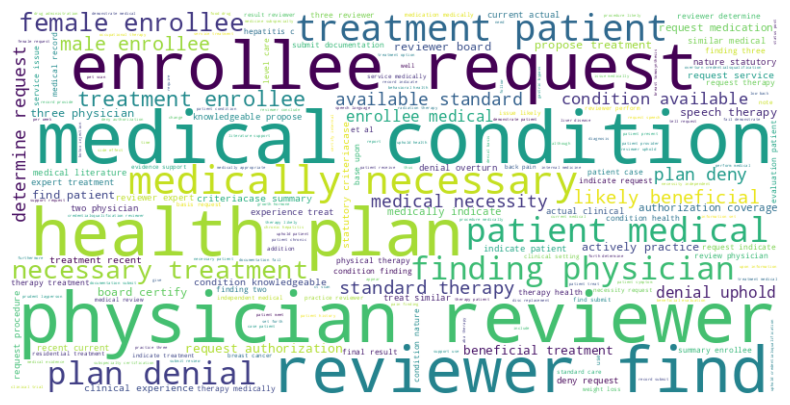

In [ ]:
def generate_wordcloud(text_data):
    wordcloud = WordCloud(
        width=800, height=400, background_color='white', max_words=200
    ).generate(' '.join(text_data))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word cloud for cleaned text
generate_wordcloud(medical_reports['Cleaned_Text'])


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

# Dictionary containing remedies and when to consult a doctor
remedies = {
    "Headache": {
        "remedy": "Stay hydrated, rest in a quiet room, and use a cold compress on your forehead.",
        "when_to_consult_a_doctor": "If headache is severe, persistent, or accompanied by vision changes and confusion."
    },
    "Piles": {
        "remedy": "Increase fiber intake, drink plenty of water, avoid spicy food, and take sitz baths.",
        "when_to_consult_a_doctor": "Seek medical help if piles cause severe pain, persistent bleeding, or do not improve with home treatment."
    },
    "Diabetes": {
        "remedy": "Maintain a balanced diet, exercise regularly, monitor blood sugar levels, and manage stress.",
        "when_to_consult_a_doctor": "Consult a doctor if blood sugar levels are consistently high or if you experience symptoms like frequent urination, extreme thirst, or unexplained weight loss."
    },
    "Cold & Flu": {
        "remedy": "Stay hydrated, get enough rest, use steam inhalation, and take honey with warm water.",
        "when_to_consult_a_doctor": "See a doctor if symptoms persist beyond 10 days, worsen over time, or include high fever and difficulty breathing."
    },
    "Acidity": {
        "remedy": "Drink cold milk, avoid spicy and oily foods, eat smaller meals, and avoid lying down immediately after eating.",
        "when_to_consult_a_doctor": "If acidity is frequent, severe, or associated with chest pain mimicking heart attack symptoms."
    },
    "Migraine": {
        "remedy": "Rest in a dark, quiet room, stay hydrated, apply cold compress, and manage stress.",
        "when_to_consult_a_doctor": "If migraines occur frequently, last more than a day, or are associated with neurological symptoms."
    },
    "Anemia": {
        "remedy": "Increase iron intake through leafy greens, red meat, and vitamin C-rich foods.",
        "when_to_consult_a_doctor": "If symptoms like dizziness, extreme fatigue, or pale skin persist."
    },
    "Anxiety": {
        "remedy": "Practice deep breathing, meditation, exercise, and avoid excessive caffeine intake.",
        "when_to_consult_a_doctor": "If anxiety disrupts daily life or leads to panic attacks."
    },
    "AIDS/HIV": {
        "remedy": "Maintain a healthy immune system with a balanced diet, exercise, and antiretroviral therapy.",
        "when_to_consult_a_doctor": "Regular follow-ups with a doctor are necessary for management."
    },
    "Acne": {
        "remedy": "Keep skin clean, avoid excessive oil-based products, and use mild cleansers.",
        "when_to_consult_a_doctor": "If acne is severe, painful, or leaves scars."
    },
    "Alcohol Addiction": {
        "remedy": "Seek therapy, join support groups, and engage in healthy hobbies.",
        "when_to_consult_a_doctor": "If withdrawal symptoms or dependency become severe."
    },
    "Infectious Diseases": {
        "remedy": "Rest, drink plenty of fluids, take prescribed antibiotics (if bacterial), and maintain hygiene.",
        "when_to_consult_a_doctor": "If symptoms worsen, fever persists beyond 3 days, or breathing difficulties occur."
    },
    "Mental Health Disorders": {
        "remedy": "Engage in therapy, practice mindfulness, exercise regularly, and maintain a healthy social life.",
        "when_to_consult_a_doctor": "If persistent sadness, anxiety, or suicidal thoughts occur."
    },
    "Autism Spectrum Disorder": {
        "remedy": "Behavioral therapy, structured routines, and speech therapy can help.",
        "when_to_consult_a_doctor": "If social interaction issues and communication difficulties persist."
    },
    "Cardiac Diseases (Heart Problems)": {
        "remedy": "Maintain a heart-healthy diet, exercise regularly, reduce stress, and monitor cholesterol.",
        "when_to_consult_a_doctor": "If experiencing chest pain, breathlessness, or irregular heartbeat."
    },
    "Pregnancy-Related Issues": {
        "remedy": "Eat nutritious food, take prenatal vitamins, exercise lightly, and stay hydrated.",
        "when_to_consult_a_doctor": "If experiencing severe cramps, bleeding, or dizziness."
    },
    "Digestive Issues": {
        "remedy": "Eat fiber-rich foods, stay hydrated, avoid spicy foods, and take probiotics.",
        "when_to_consult_a_doctor": "If severe abdominal pain, vomiting, or persistent diarrhea occurs."
    },
    "Orthopedic Problems (Bone & Joint Issues)": {
        "remedy": "Perform physiotherapy, maintain a calcium-rich diet, and use cold/hot compresses.",
        "when_to_consult_a_doctor": "If pain persists or swelling and immobility occur."
    },
    "Neurological Disorders": {
        "remedy": "Follow a healthy diet, manage stress, get enough sleep, and practice brain exercises.",
        "when_to_consult_a_doctor": "If experiencing memory loss, seizures, or difficulty in movement."
    }
}

def get_remedy(disease):
    if disease in remedies:
        return remedies[disease]["remedy"], remedies[disease]["when_to_consult_a_doctor"]
    else:
        return "Remedy not found", "Consult a doctor if symptoms worsen or persist."

# Get the list of diseases
disease_list = list(remedies.keys())

# Create the Gradio interface
demo = gr.Interface(
    fn=get_remedy,
    inputs=gr.Dropdown(disease_list, label="Select a Disease"),
    outputs=[
        gr.Textbox(label="Home Remedy"),
        gr.Textbox(label="When to Consult a Doctor")
    ],
    title="Health Remedies & Advice",
    description="Select a disease to get home remedies and guidance on when to consult a doctor."
)

# Launch the interface
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bdcb852746220db6a9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
